![TS banner](banner.png)

# Fitting JWST NIRSpec/G395H transit lightcurves of HAT-P-14b via `transitspectroscopy`
**Author**: Néstor Espinoza (Assistant Astronomer; Mission Scientist for Exoplanet Science)
**Last updated**: June 4th, 2024

## Motivation & Data Description

This notebook takes over the previous notebook, by performing white-light lightcurve fits to the HAT-P-14b data using both `juliet` and `ray`. Let's first load the data products:

In [1]:
CRDS_PATH='/Users/nespinoza/crds_cache'
CRDS_SERVER_URL='https://jwst-crds.stsci.edu'

# Need to set these enviromental variables for this notebook to work properly:
%set_env CRDS_PATH $CRDS_PATH
%set_env CRDS_SERVER_URL $CRDS_SERVER_URL

env: CRDS_PATH=/Users/nespinoza/crds_cache
env: CRDS_SERVER_URL=https://jwst-crds.stsci.edu


In [2]:
import jwst
import transitspectroscopy as ts
import juliet
import ray

Some useful libraries:

In [3]:
import glob
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import median_filter

import seaborn as sns
sns.set_style('ticks')

Below, we use the `transitspectroscopy` library to download, calibrate and perform tracing and extraction of NIRSpec/G395H data for HAT-P-14 b.

## 1. Data loading & white-light lightcurve analysis

First, let's use `transitspectroscopy` to load our products from the previous run:

In [4]:
output_folder = 'JWSTdata/ts_outputs/'

In [5]:
nrs1_filenames = glob.glob(output_folder+'jw01118005001_04101_*_nrs1_tsojumpstep_1_ramp_fitstep.fits')
nrs2_filenames = glob.glob(output_folder+'jw01118005001_04101_*_nrs2_tsojumpstep_1_ramp_fitstep.fits')

In [6]:
nrs1_dataset = ts.jwst.load(nrs1_filenames, outputfolder = 'JWSTdata')
nrs2_dataset = ts.jwst.load(nrs2_filenames, outputfolder = 'JWSTdata')

	    - Instrument/Mode: NIRSpec/G395H

	    - Instrument/Mode: NIRSpec/G395H



Prepare input dictionary and extract spectra at a 2-pixel aperture (for NIRSpec/G395H):

In [7]:
input_dictionary_nrs1 = {}
input_dictionary_nrs2 = {}

nsegments = len(nrs1_dataset.rateints_per_segment)

input_dictionary_nrs1['rampstep'] = nrs1_dataset.rateints_per_segment
input_dictionary_nrs1['times'] = nrs1_dataset.times

input_dictionary_nrs2['rampstep'] = nrs2_dataset.rateints_per_segment
input_dictionary_nrs2['times'] = nrs2_dataset.times

input_dictionary_nrs1['ints_per_segment'] = []
input_dictionary_nrs2['ints_per_segment'] = []

for i in range(nsegments):

    input_dictionary_nrs1['ints_per_segment'].append( nrs1_dataset.rateints_per_segment[i].data.shape[0] )
    input_dictionary_nrs2['ints_per_segment'].append( nrs2_dataset.rateints_per_segment[i].data.shape[0] )
    

Run (or load) this:

In [8]:
all_outputs_nrs1 = {}
all_outputs_nrs2 = {}
aperture = 2 # pixels

all_outputs_nrs1[aperture] = ts.jwst.stage2(input_dictionary_nrs1, 
                                            nthreads = 10, 
                                            outputfolder = output_folder, 
                                            suffix = str(aperture)+'pix', 
                                            aperture_radius = aperture)

all_outputs_nrs2[aperture] = ts.jwst.stage2(input_dictionary_nrs2, 
                                            nthreads = 10, 
                                            outputfolder = output_folder, 
                                            suffix = str(aperture)+'pix', 
                                            aperture_radius = aperture)

	 >> Processing through spectral tracing and extraction:

	    - TSO total duration: 6.0 hours
	    - Instrument/Mode: NIRSpec/G395H

	    - Detector/Subarray: NRS1/SUB2048

	 >> Traces found in file JWSTdata/ts_outputs/pipeline_outputs/traces_2pix_nrs1.pkl. Loading...
	 >> Spectra found in file JWSTdata/ts_outputs/pipeline_outputs/spectra_2pix_nrs1.pkl. Loading...
	 >> Processing through spectral tracing and extraction:

	    - TSO total duration: 6.0 hours
	    - Instrument/Mode: NIRSpec/G395H

	    - Detector/Subarray: NRS2/SUB2048

	 >> Traces found in file JWSTdata/ts_outputs/pipeline_outputs/traces_2pix_nrs2.pkl. Loading...
	 >> Spectra found in file JWSTdata/ts_outputs/pipeline_outputs/spectra_2pix_nrs2.pkl. Loading...


Check white-light lightcurves look good:

(0.992, 1.0025)

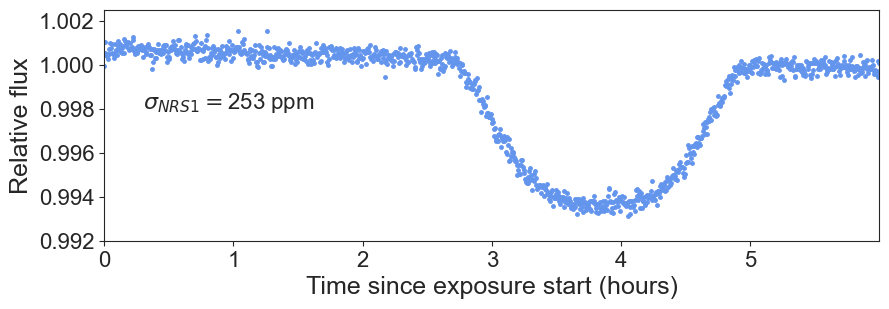

In [9]:
plt.figure(figsize=(10,3))

tsincestart_nrs1 = (input_dictionary_nrs1['times'] - input_dictionary_nrs1['times'][0])*24
plt.plot(tsincestart_nrs1, all_outputs_nrs1[aperture]['whitelight'], '.', color = 'cornflowerblue')
rms_nrs1 = np.sqrt(np.var(all_outputs_nrs1[aperture]['whitelight'][0:100]))*1e6
plt.text(0.3, 0.998, '$\sigma_{NRS1} = $'+'{0:.0f} ppm'.format(rms_nrs1), fontsize = 16)

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlim(np.min(tsincestart_nrs1), np.max(tsincestart_nrs1))
plt.ylim(0.992, 1.0025)

(0.992, 1.0025)

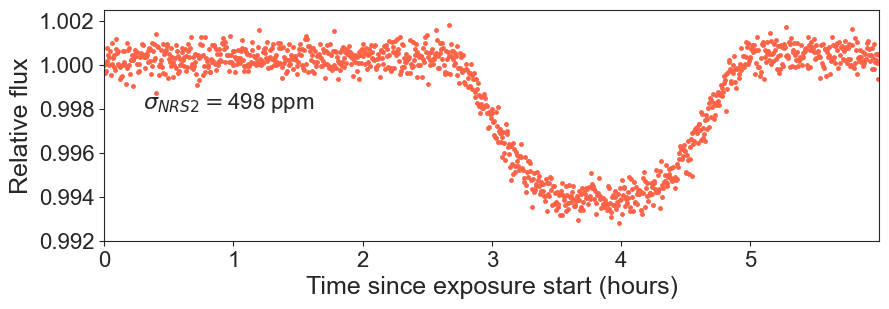

In [10]:
plt.figure(figsize=(10,3))

tsincestart_nrs2 = (input_dictionary_nrs2['times'] - input_dictionary_nrs2['times'][0])*24
plt.plot(tsincestart_nrs2, all_outputs_nrs2[aperture]['whitelight'], '.', color = 'tomato')
rms_nrs2 = np.sqrt(np.var(all_outputs_nrs2[aperture]['whitelight'][0:100]))*1e6
plt.text(0.3, 0.998, '$\sigma_{NRS2} = $'+'{0:.0f} ppm'.format(rms_nrs2), fontsize = 16)

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlim(np.min(tsincestart_nrs2), np.max(tsincestart_nrs2))
plt.ylim(0.992, 1.0025)

They do! 

Next, we need to fit those lightcurves. This is needed because we need to use the best time-of-transit center we can for this dataset. To make the fit as fast as possible, we put some strong priors on the orbital parameters. We can get those from the NASA Exoplanet Archive (https://exoplanetarchive.ipac.caltech.edu/). The page for the planet (https://exoplanetarchive.ipac.caltech.edu/overview/HAT-P-14b) lists various possibilities to get this info --- we use the one from Simpson+2011:

In [11]:
# Priors:
ar, ar_err = 8.4, 0.54
b, b_err = 0.924, 0.02
p, p_err = 0.0793, 0.001 

# Fixed:
P = 4.627649
ecc = 0.066
omega = 111.

Set priors:

In [12]:
tmin, tmax = np.min(input_dictionary_nrs1['times']), np.max(input_dictionary_nrs1['times'])

# Name of the parameters to be fit:
params = ['P_p1', 't0_p1', 'a_p1', 'b_p1', 'ecc_p1', 'omega_p1',\
          'p_p1_NRS1', 'q1_NRS1', 'q2_NRS1', 'p_p1_NRS2', 'q1_NRS2', 'q2_NRS2', \
          'mdilution_NRS1', 'mflux_NRS1', 'sigma_w_NRS1', 'theta0_NRS1', \
          'mdilution_NRS2', 'mflux_NRS2', 'sigma_w_NRS2', 'theta0_NRS2']

# Distributions:
dists = ['fixed', 'uniform', 'normal', 'truncatednormal', 'fixed', 'fixed',
         'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform',\
         'fixed', 'normal', 'loguniform', 'uniform', \
         'fixed', 'normal', 'loguniform', 'uniform']

# Hyperparameters:
hyperps = [P, [tmin, tmax], [ar, ar_err], [b, b_err, 0., 1.], ecc, omega,
           [0., 0.2], [0., 1.], [0.,1.], [0., 0.2], [0., 1.], [0., 1.], \
            1.0, [0., 0.1], [10., 1000.], [-10,10], \
           1.0, [0., 0.1], [10., 1000.], [-10,10]]

priors = juliet.generate_priors(params, dists, hyperps)

Set linear regressors:

In [13]:
def standarize_regressors(x):
    
    new_x = (x - np.mean(x)) / np.sqrt(np.var(x))
    
    return new_x

In [14]:
times_nrs1 = input_dictionary_nrs1['times']
times_nrs2 = input_dictionary_nrs2['times']

linear_regressor_nrs1 = standarize_regressors(times_nrs1)
linear_regressor_nrs2 = standarize_regressors(times_nrs2)

linear_regressors = {}
linear_regressors['NRS1'] = np.zeros([len(linear_regressor_nrs1), 1])
linear_regressors['NRS1'][:, 0] = linear_regressor_nrs1

linear_regressors['NRS2'] = np.zeros([len(linear_regressor_nrs2), 1])
linear_regressors['NRS2'][:, 0] = linear_regressor_nrs2

In [15]:
all_outputs_nrs2[aperture]['whitelight_err'].shape

(1139,)

Prepare fluxes for fit:

In [16]:
times, fluxes, fluxes_error = {}, {}, {}
    
times['NRS1'], fluxes['NRS1'], fluxes_error['NRS1'] = times_nrs1, \
                                                      all_outputs_nrs1[aperture]['whitelight'], \
                                                      all_outputs_nrs1[aperture]['whitelight_err']

    
times['NRS2'], fluxes['NRS2'], fluxes_error['NRS2'] = times_nrs2, \
                                                      all_outputs_nrs2[aperture]['whitelight'], \
                                                      all_outputs_nrs2[aperture]['whitelight_err']

In [17]:
dataset_white_light = juliet.load(priors=priors, t_lc=times, y_lc=fluxes, \
                                            yerr_lc=fluxes_error, linear_regressors_lc = linear_regressors,\
                                            out_folder=output_folder, \
                                            ld_laws = 'quadratic')

result_white_light = dataset_white_light.fit(sampler = 'dynamic_dynesty')

Detected dynamic_dynesty sampler output files --- extracting from JWSTdata/ts_outputs/_dynesty_DNS_posteriors.pkl


Check fit:

(0.992, 1.0025)

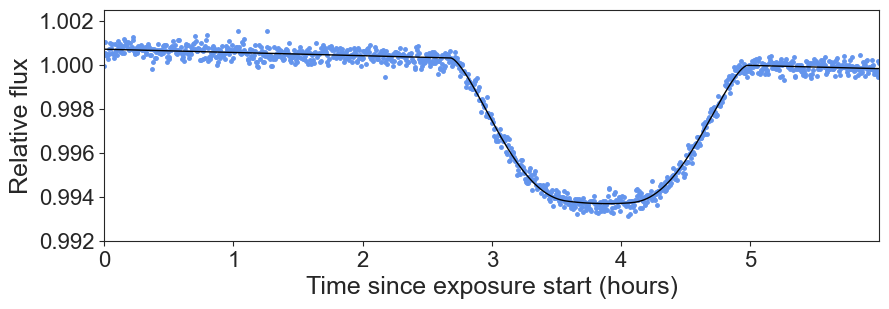

In [18]:
plt.figure(figsize=(10,3))

model_nrs1 = result_white_light.lc.evaluate('NRS1')

tsincestart_nrs1 = (input_dictionary_nrs1['times'] - input_dictionary_nrs1['times'][0])*24

plt.plot(tsincestart_nrs1, all_outputs_nrs1[aperture]['whitelight'], '.', color = 'cornflowerblue')
plt.plot(tsincestart_nrs1, model_nrs1, 'k-', lw = 1)

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlim(np.min(tsincestart_nrs1), np.max(tsincestart_nrs1))
plt.ylim(0.992, 1.0025)

(-1200.0, 1200.0)

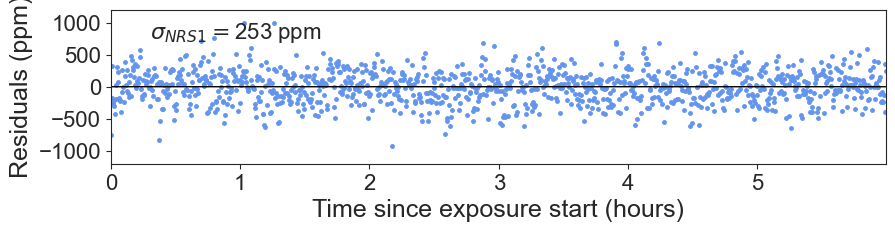

In [19]:
plt.figure(figsize=(10,2))

residuals = all_outputs_nrs1[aperture]['whitelight'] - model_nrs1
plt.plot(tsincestart_nrs1, residuals * 1e6, '.', color = 'cornflowerblue')
plt.plot(tsincestart_nrs1, np.zeros(tsincestart_nrs1.shape), 'k-', lw = 1)
rms_nrs1 = np.sqrt(np.var(residuals))*1e6
plt.text(0.3, 750, '$\sigma_{NRS1} = $'+'{0:.0f} ppm'.format(rms_nrs1), fontsize = 16)

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Residuals (ppm)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlim(np.min(tsincestart_nrs1), np.max(tsincestart_nrs1))
plt.ylim(-1200,1200)

(0.992, 1.0025)

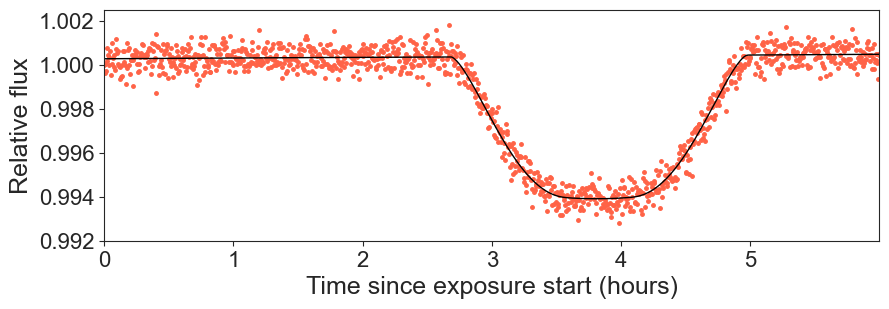

In [20]:
plt.figure(figsize=(10,3))

model_nrs2 = result_white_light.lc.evaluate('NRS2')

tsincestart_nrs2 = (input_dictionary_nrs2['times'] - input_dictionary_nrs2['times'][0])*24

plt.plot(tsincestart_nrs2, all_outputs_nrs2[aperture]['whitelight'], '.', color = 'tomato')
plt.plot(tsincestart_nrs2, model_nrs2, 'k-', lw = 1)

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlim(np.min(tsincestart_nrs2), np.max(tsincestart_nrs2))
plt.ylim(0.992, 1.0025)

(-1200.0, 1200.0)

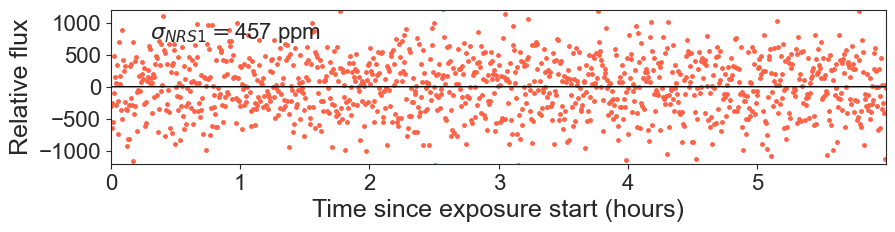

In [21]:
plt.figure(figsize=(10,2))

residuals = all_outputs_nrs2[aperture]['whitelight'] - model_nrs2
plt.plot(tsincestart_nrs2, residuals * 1e6, '.', color = 'tomato')
plt.plot(tsincestart_nrs2, np.zeros(tsincestart_nrs2.shape), 'k-', lw = 1)
rms_nrs2 = np.sqrt(np.var(residuals))*1e6
plt.text(0.3, 750, '$\sigma_{NRS1} = $'+'{0:.0f} ppm'.format(rms_nrs2), fontsize = 16)

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.xlim(np.min(tsincestart_nrs2), np.max(tsincestart_nrs2))
plt.ylim(-1200,1200)

Are we getting a good constraint on the time-of-transit center?

In [22]:
t0_posterior = result_white_light.posteriors['posterior_samples']['t0_p1']
t0, t0_err = np.median(t0_posterior), np.sqrt(np.var(t0_posterior))

print('t0 is',t0,'with an error of {0:.2f} seconds.'.format(t0_err*24*3600.))

t0 is 2459729.706779847 with an error of 5.51 seconds.


Nice!